In [57]:
import sys
import networkx as nx # type: ignore
import graphviz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dowhy import CausalModel
import statsmodels.formula.api as smf

In [70]:
# Clean data
df = pd.read_csv("../data/processed/data.csv")

In [71]:
causal_graph = """digraph {
is_delivery_late;
Rating;
Product_category;
Product_size;
No_photos;
Product_price;
shipping_method;
freight_value;
distance_km;
region;
season;
seller_hist_rating;
customer_avg_score;
customer_service;

Product_category_encoded -> is_delivery_late;
Product_category_encoded -> Rating;
Product_category_encoded -> Product_price;
Product_category_encoded -> Product_size;
Product_category_encoded -> No_photos;

Product_size -> shipping_method;
Product_size -> freight_value;

No_photos -> Rating;

Product_price -> Rating;

shipping_method -> is_delivery_late;

freight_value -> is_delivery_late;
freight_value -> Rating;

distance_km -> season;
distance_km -> freight_value;
distance_km -> is_delivery_late;

region -> season;
region -> freight_value;
region -> is_delivery_late;


season -> is_delivery_late;
season -> Rating;

seller_hist_rating -> Product_price;

customer_avg_score -> seller_hist_rating;

customer_service -> Rating;

is_delivery_late -> Rating;
}"""

In [72]:
df['Product_weight_kg'] = df['Product_weight_kg'].fillna(df['Product_weight_kg'].mean())

df['distance_km'] = df['distance_km'].fillna(df['distance_km'].mean())

df['Product_size'] = df['Product_size'].fillna(df['Product_size'].mean())

df['customer_avg_score'] = df['customer_avg_score'].fillna(df['customer_avg_score'].mean())

df['No_photos'] = df['No_photos'].fillna(df['No_photos'].mean())

df['Product_price'] = df['Product_price'].fillna(df['Product_price'].mean())

df['freight_value'] = df['freight_value'].fillna(df['freight_value'].mean())

In [ ]:
methods_dict = {
    "Propensity Score Matching": "backdoor.propensity_score_matching",
    "Propensity Score Stratification": "backdoor.propensity_score_stratification",
    "Propensity Score-based Inverse Weighting": "backdoor.propensity_score_weighting",
    "Linear Regression": "backdoor.linear_regression",
    "Generalized Linear Models": "backdoor.generalized_linear_model",
    "Instrumental Variables": "iv.instrumental_variable",
    "Regression Discontinuity": "iv.regression_discontinuity",
    "Two Stage Regression": "frontdoor.two_stage_regression"
}


In [84]:


class MakeModel:

    def __init__(self):
        pass


    def make_causal_model(self, data, causal_graph, treatment, outcome):
        
        model = CausalModel(data=data,
                            graph=causal_graph.replace("\n", " "),
                            treatment=treatment,
                            outcome=outcome)
        return model


    def identify_causal_effect(self, model):
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
        return identified_estimand


    def estimate_causal_effect(self, model, identified_estimand, method_name, target_units):
        causal_estimate = model.estimate_effect(identified_estimand,
                                                method_name=method_name,
                                                target_units = target_units)
        return causal_estimate
        
    def refute_causal_estimate(self, model, identified_estimand, causal_estimate, method_name, placebo_type):
        refutation = model.refute_estimate(identified_estimand, 
                                    causal_estimate, 
                                    method_name=method_name,
                                    placebo_type=placebo_type, 
                                    num_simulations=20)
        return refutation


In [85]:
causal_model = MakeModel()
model = causal_model.make_causal_model(data=df, causal_graph=causal_graph, treatment='is_delivery_late', outcome='Rating')

/Users/juanherrera/Desktop/causal-attribution-analysis/venv/lib/python3.9/site-packages/dowhy/causal_model.py:582: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


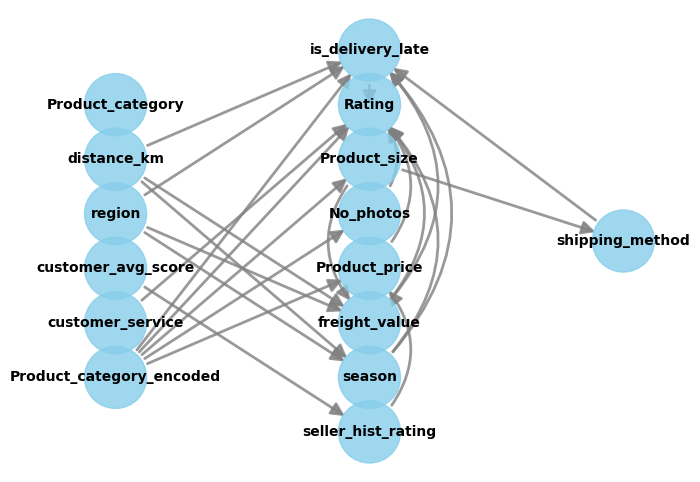

In [86]:
model.view_model()

In [87]:
identified_estimand = causal_model.identify_causal_effect(model=model)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                  
───────────────────(E[Rating|season,Product_category_encoded,freight_value])
d[is_delivery_late]                                                         
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→Rating then P(Rating|is_delivery_late,season,Product_category_encoded,freight_value,U) = P(Rating|is_delivery_late,season,Product_category_encoded,freight_value)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [89]:
method_name = 'backdoor.propensity_score_weighting'
target_units = 'att'

causal_estimate = causal_model.estimate_causal_effect(model=model, identified_estimand=identified_estimand, method_name=method_name, target_units=target_units)

In [90]:
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                  
───────────────────(E[Rating|season,Product_category_encoded,freight_value])
d[is_delivery_late]                                                         
Estimand assumption 1, Unconfoundedness: If U→{is_delivery_late} and U→Rating then P(Rating|is_delivery_late,season,Product_category_encoded,freight_value,U) = P(Rating|is_delivery_late,season,Product_category_encoded,freight_value)

## Realized estimand
b: Rating~is_delivery_late+season+Product_category_encoded+freight_value
Target units: att

## Estimate
Mean value: -1.8289235868800975



In [92]:
method_name='placebo_treatment_refuter'
placebo_type='permute'


refutation = causal_model.refute_causal_estimate(model=model,
                                     identified_estimand=identified_estimand, 
                                     causal_estimate=causal_estimate,
                                     method_name=method_name,
                                     placebo_type=placebo_type)

In [94]:
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:-1.8289235868800975
New effect:0.01746563874214633
p value:0.17295704178998716

